# Customer Segmentation

Objective of the Project:

Perform cluster analysis on customer data from a grocery store to segment customers into distinct groups.
Use these segments to derive actionable business insights and recommendations.

## 1. Importing Libraries

In [1]:
#Importing the Libraries
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

## 2. Data Reading 

In [2]:
#Loading the dataset
data = pd.read_csv("marketing_campaign.csv", sep="\t")
print("Number of datapoints:", len(data))
data.head()

Number of datapoints: 2240


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


## 3. DATA Handeling

In this section
* Data Cleaning
* Feature Engineering 

In [3]:
#Information on features 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

**From the above output, we can conclude and note that:**

* There are missing values in income
* Dt_Customer that indicates the date a customer joined the database is not parsed as DateTime
* There are some categorical features in our data frame; as there are some features in dtype: object). So we will need to encode them into numeric forms later. 

In [4]:
#To remove the NA values
data = data.dropna()
print("The total number of data-points after removing the rows with missing values are:", len(data))

The total number of data-points after removing the rows with missing values are: 2216


In the next step, I am going to create a feature out of "Dt_Customer" that indicates the number of days a customer is registered in the firm's database. However, in order to keep it simple, I am taking this value relative to the most recent customer in the record. 

Thus to get the values I must check the newest and oldest recorded dates. 

In [5]:
data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"],format='mixed')
dates = []
for i in data["Dt_Customer"]:
    i = i.date()
    dates.append(i)  
#Dates of the newest and oldest recorded customer
print("The newest customer's enrolment date in therecords:",max(dates))
print("The oldest customer's enrolment date in the records:",min(dates))


The newest customer's enrolment date in therecords: 2014-12-06
The oldest customer's enrolment date in the records: 2012-01-08


Creating a feature "Customer_For" of the number of days the customers started to shop in the store relative to the last recorded date

In [6]:
#Created a feature "Customer_For"
days = []
d1 = max(dates)
for i in dates:
    delta = d1 - i
    days.append(delta)
data["Customer_For"] = days
data["Customer_For"] = pd.to_numeric(data["Customer_For"], errors="coerce")

Now we will be exploring the unique values in the categorical features to get a clear idea of the data.  

In [7]:
print("Total categories in the feature Marital_Status:\n", data["Marital_Status"].value_counts(), "\n")
print("Total categories in the feature Education:\n", data["Education"].value_counts())

Total categories in the feature Marital_Status:
 Marital_Status
Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64 

Total categories in the feature Education:
 Education
Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: count, dtype: int64


In the next bit, I will be performing the following steps to engineer some new features:

* Extract the "Age" of a customer by the "Year_Birth" indicating the birth year of the respective person.
* Create another feature "Spent" indicating the total amount spent by the customer in various categories over the span of two years.
* Create another feature "Living_With" out of "Marital_Status" to extract the living situation of couples.
* Create a feature "Children" to indicate total children in a household that is, kids and teenagers.
* To get further clarity of household, Creating feature indicating "Family_Size"
* Create a feature "Is_Parent" to indicate parenthood status
* Lastly, I will create three categories in the "Education" by simplifying its value counts.
* Dropping some of the redundant features

In [8]:
#Feature Engineering
#Age of customer today 
data["Age"] = 2016-data["Year_Birth"]

#Total spendings on various items
data["Spent"] = data["MntWines"]+ data["MntFruits"]+ data["MntMeatProducts"]+ data["MntFishProducts"]+ data["MntSweetProducts"]+ data["MntGoldProds"]

#Deriving living situation by marital status"Alone"
data["Living_With"]=data["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})

#Feature indicating total children living in the household
data["Children"]=data["Kidhome"]+data["Teenhome"]

#Feature for total members in the householde
data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner":2})+ data["Children"]

#Feature pertaining parenthood
data["Is_Parent"] = np.where(data.Children> 0, 1, 0)

#Segmenting education levels in three groups
data["Education"]=data["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

#For clarity
data=data.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

#Dropping some of the redundant features
to_drop = ["Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
data = data.drop(to_drop, axis=1)

Now that we have some new features let's have a look at the data's stats. 

In [9]:
data.describe()

,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_For,Age,Spent,Children,Family_Size,Is_Parent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2.216000e+03,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,...,0.064079,0.013538,0.009477,0.150271,4.423735e+16,47.179603,607.075361,0.947202,2.592509,0.714350
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,...,0.244950,0.115588,0.096907,0.357417,2.008532e+16,11.985554,602.900476,0.749062,0.905722,0.451825
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,20.000000,5.000000,0.000000,1.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,2.937600e+16,39.000000,69.000000,0.000000,2.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,...,0.000000,0.000000,0.000000,0.000000,4.432320e+16,46.000000,396.500000,1.000000,3.000000,1.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,...,0.000000,0.000000,0.000000,0.000000,5.927040e+16,57.000000,1048.000000,1.000000,3.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,1.000000,1.000000,9.184320e+16,123.000000,2525.000000,3.000000,5.000000,1.000000


In [10]:
numerical_features = data.select_dtypes(include=['number']).columns.tolist()

The above stats show some discrepancies in mean Income and Age and max Income and age.

Do note that  max-age is 123 years, As I calculated the age that would be today (i.e. 2015) and the data is old.

I must take a look at the broader view of the data. 
I will plot some of the selected features.

## 4. EDA

### 4.1 Probability Distribution plot

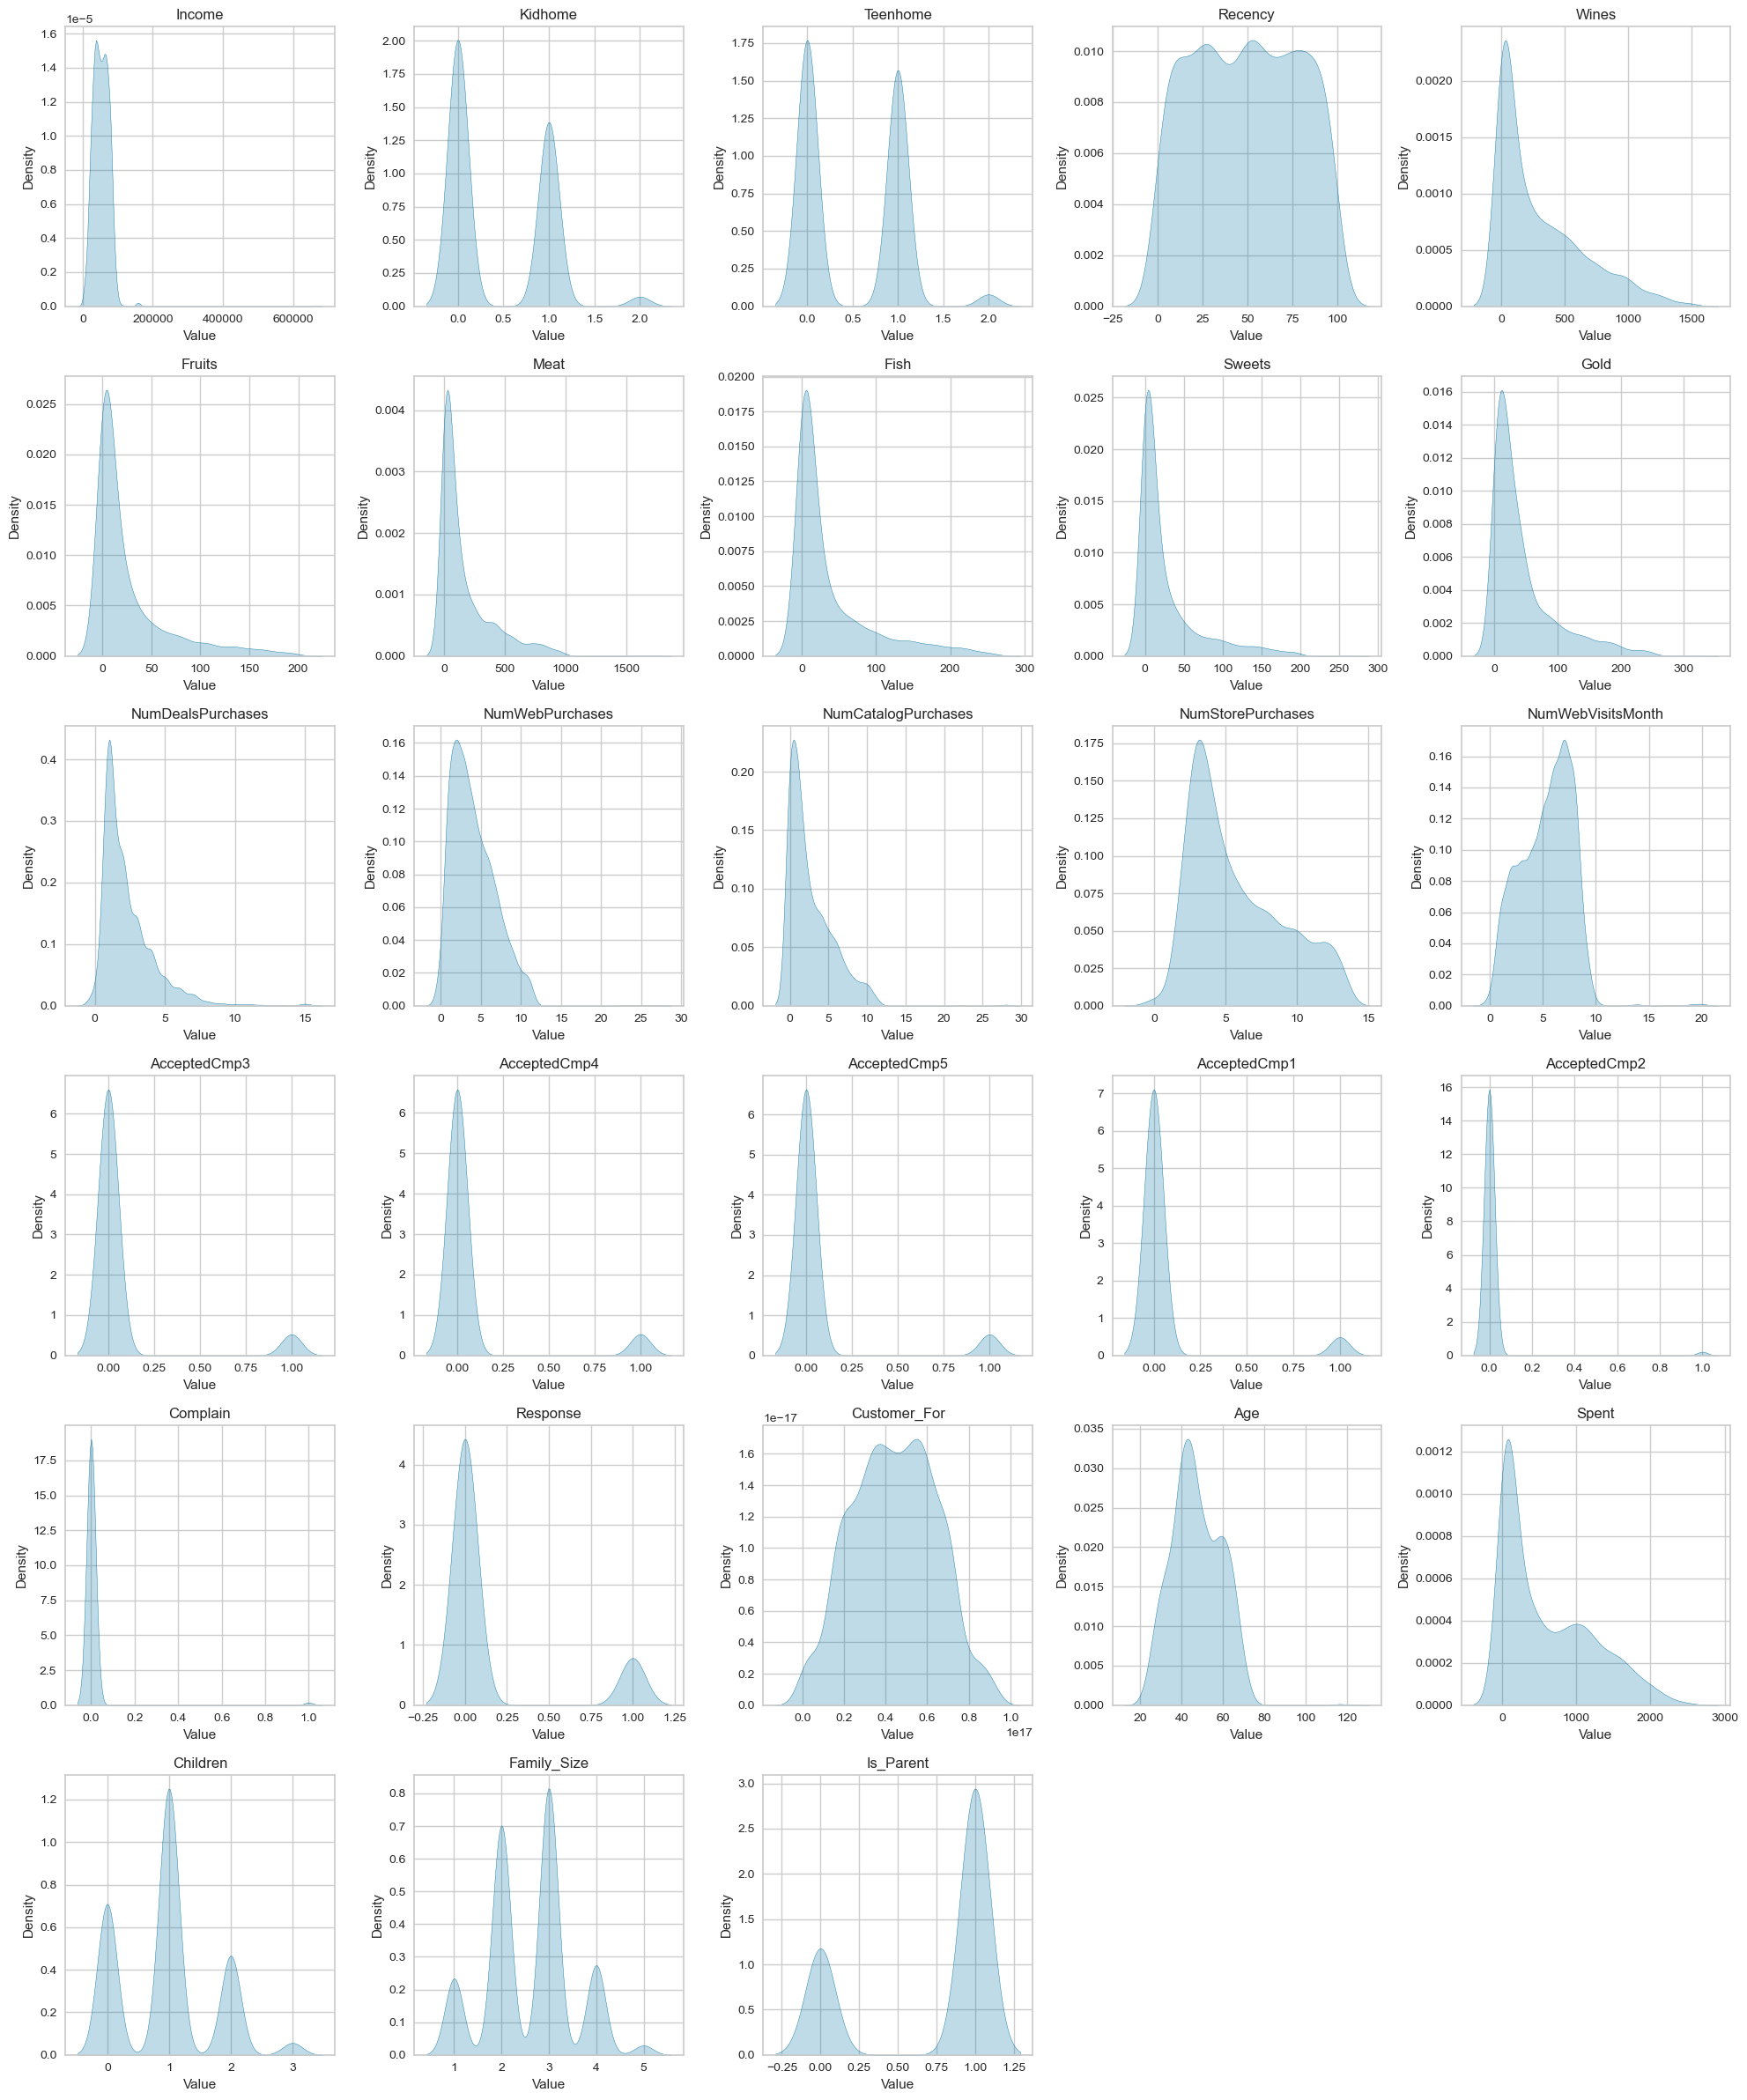

In [11]:
# Number of features to plot
num_features = len(numerical_features)

# Determine the number of rows needed for the grid
ncols = 5
nrows = (num_features + ncols - 1) // ncols  # Calculate rows needed

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 4 * nrows))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plot PDFs for each numerical feature
for i, feature in enumerate(numerical_features):
    sns.kdeplot(data[feature], fill=True, ax=axes[i])
    axes[i].set_title(feature)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Density')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


### 4.2 Box-plot

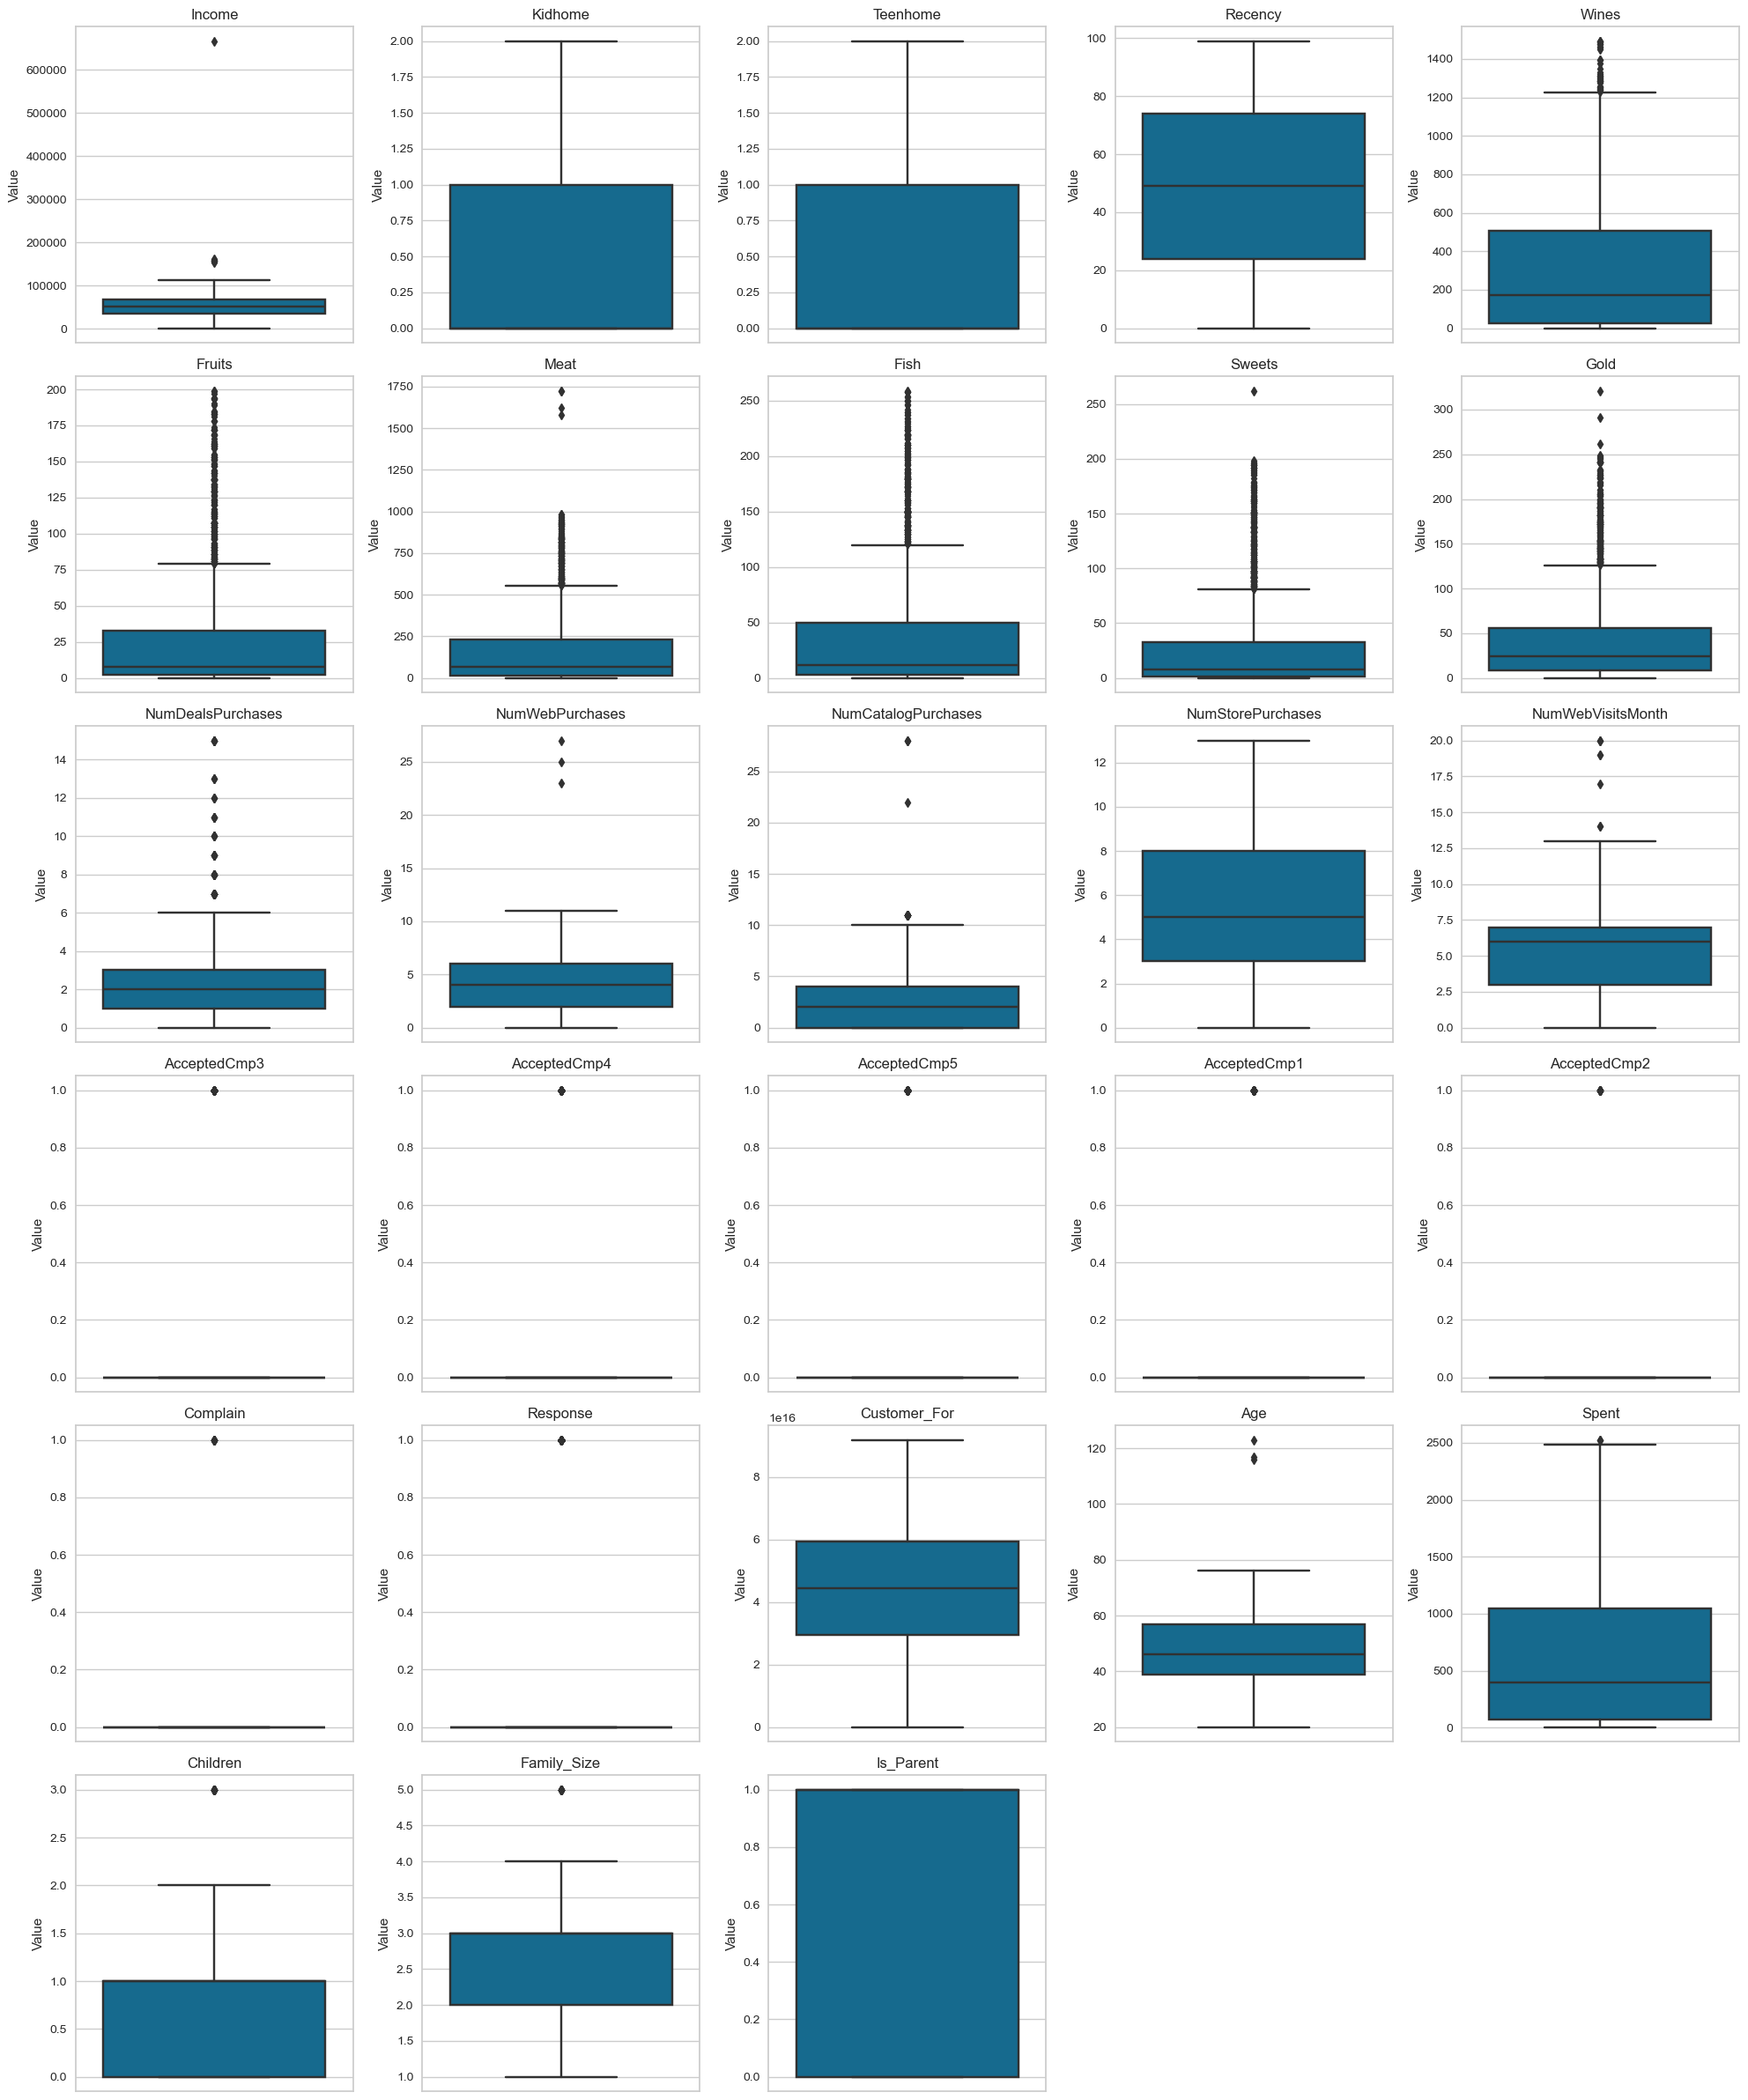

In [12]:
# Create subplots for box plots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 4 * nrows))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plot Box Plots for each numerical feature
for i, feature in enumerate(numerical_features):
    sns.boxplot(y=data[feature], ax=axes[i])
    axes[i].set_title(feature)
    axes[i].set_ylabel('Value')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


Clearly, there are a few outliers in the Income and Age features. 
I will be deleting the outliers in the data. 

In [13]:
#Dropping the outliers by setting a cap on Age and income. 
data = data[(data["Age"]<90)]
data = data[(data["Income"]<600000)]
print("The total number of data-points after removing the outliers are:", len(data))

The total number of data-points after removing the outliers are: 2212


Next, let us look at the correlation amongst the features. 
(Excluding the categorical attributes at this point)

### 4.3 Correlation Matrix

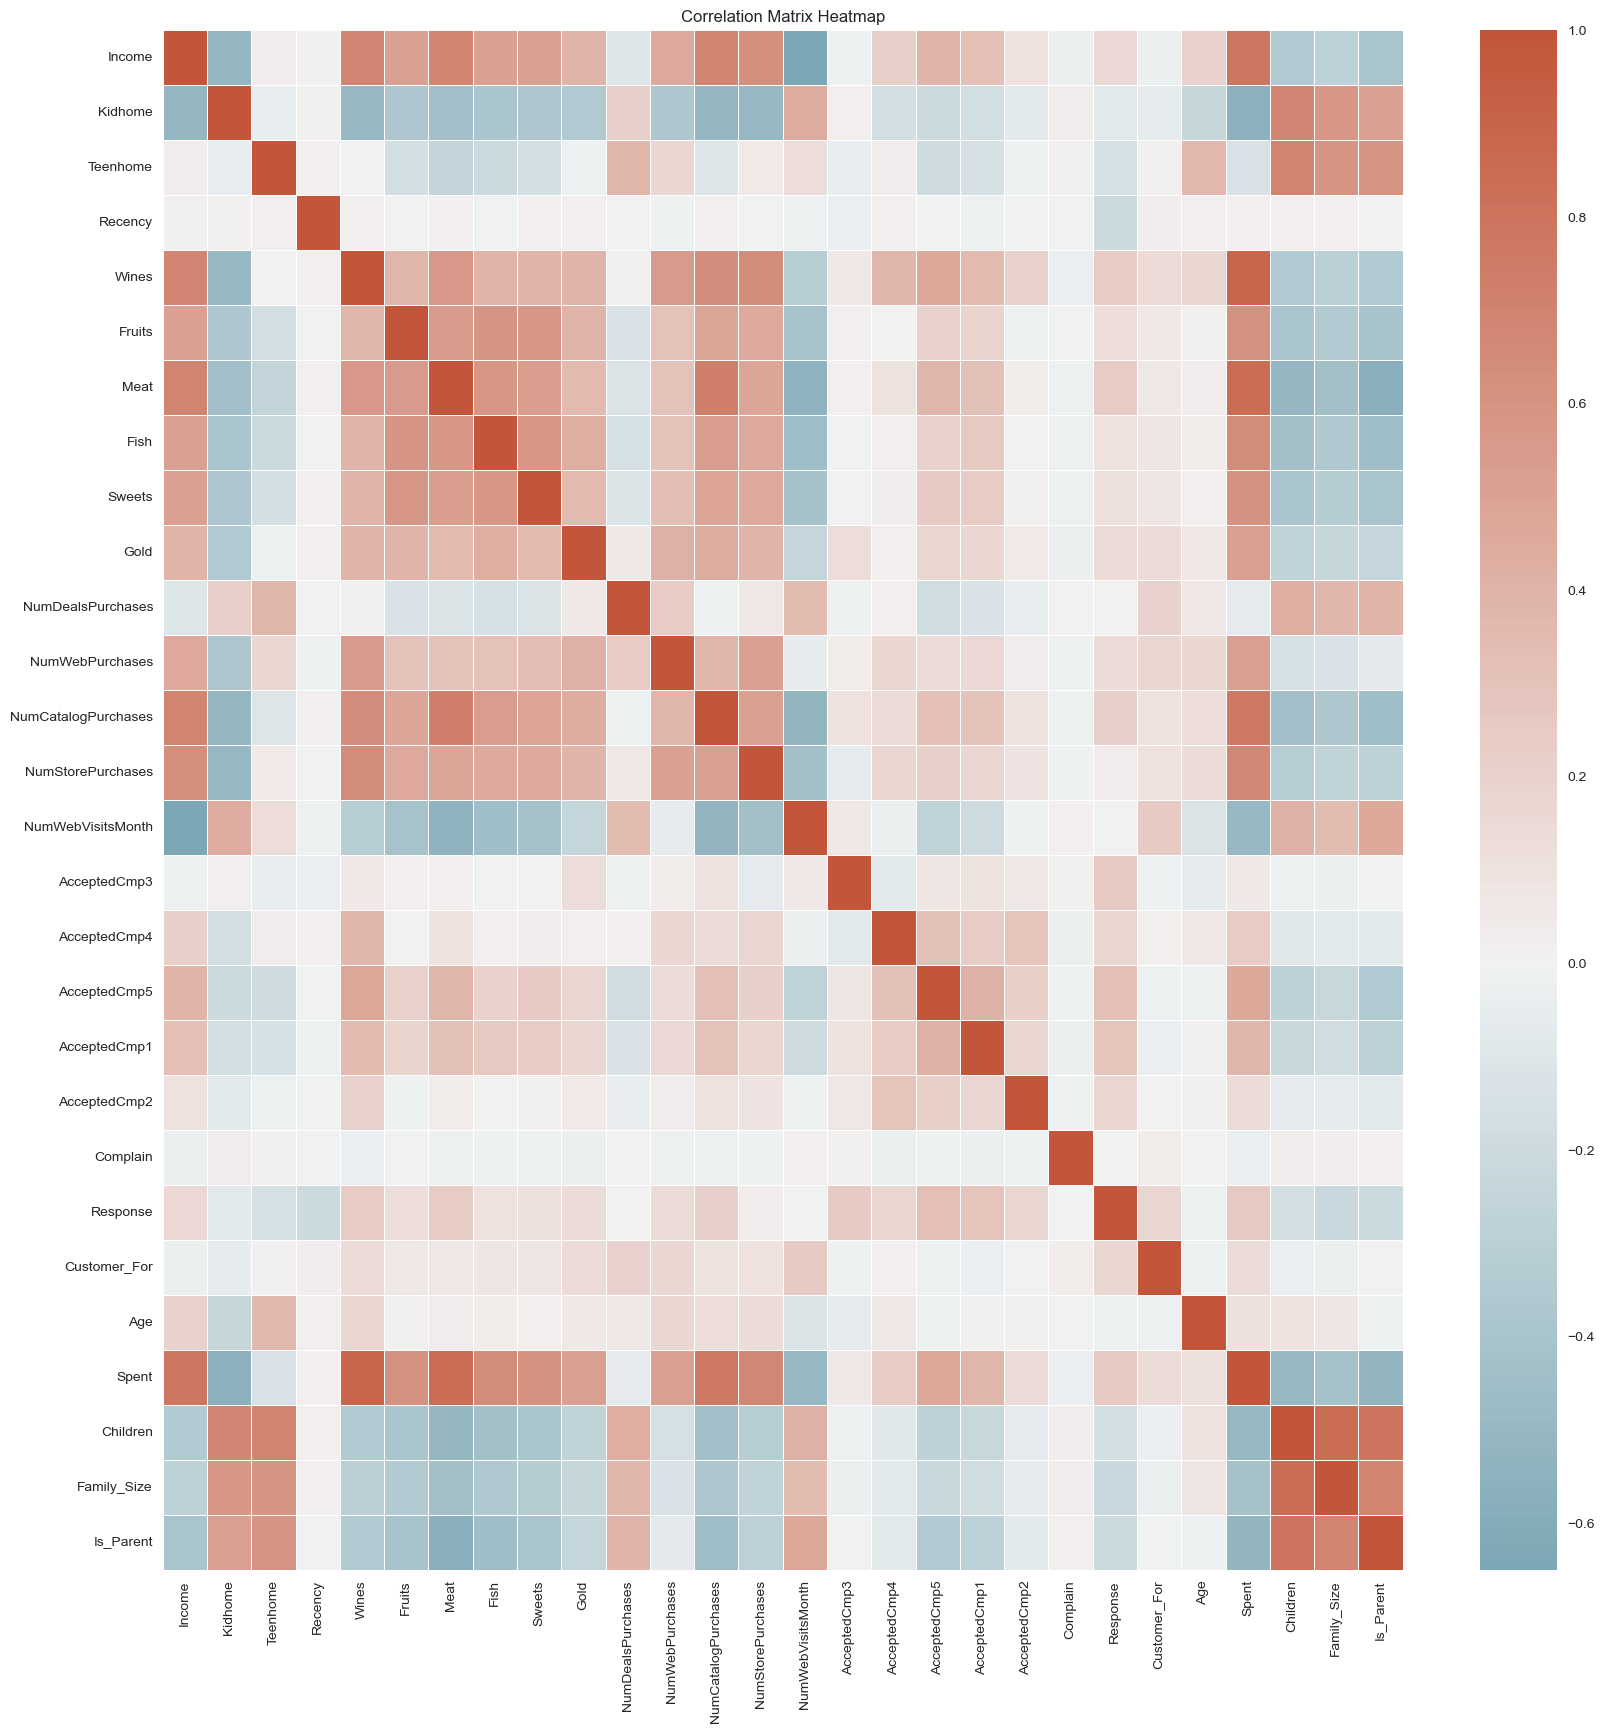

In [14]:
#correlation matrix
corrmat= data[numerical_features].corr()
# Define a colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True)
plt.figure(figsize=(20, 20))
sns.heatmap(corrmat, cmap=cmap, center=0, fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

## 5. Data Prepatation

In [15]:
#Get list of categorical variables
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Education', 'Marital_Status', 'Living_With']


In [16]:
#Label Encoding the object dtypes.
LE=LabelEncoder()
for i in object_cols:
    data[i]=data[[i]].apply(LE.fit_transform)
    
print("All features are now numerical")

All features are now numerical


In [17]:
#Creating a copy of data
ds = data.copy()
# creating a subset of dataframe by dropping the features on deals accepted and promotions
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
ds = ds.drop(cols_del, axis=1)
#Scaling
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )
print("All features are now scaled")

All features are now scaled


In [18]:
#Scaled data to be used for reducing the dimensionality
print("Dataframe to be used for further modelling:")
scaled_ds.head()

Dataframe to be used for further modelling:


,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,-0.893586,0.254760,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,...,2.503607,-0.555814,0.692181,1.973583,1.018352,1.676245,-1.349603,-1.264598,-1.758359,-1.581139
1,-0.893586,0.254760,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,...,-0.571340,-1.171160,-0.132545,-1.665144,1.274785,-0.963297,-1.349603,1.404572,0.449070,0.632456
2,-0.893586,1.183144,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,...,-0.229679,1.290224,-0.544908,-0.172664,0.334530,0.280110,0.740959,-1.264598,-0.654644,-1.581139
3,-0.893586,1.183144,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,...,-0.913000,-0.555814,0.279818,-1.923210,-1.289547,-0.920135,0.740959,0.069987,0.449070,0.632456
4,0.571657,-0.673624,0.294307,1.040021,-0.929699,1.554453,-0.392257,0.419540,-0.218684,0.152508,...,0.111982,0.059532,-0.132545,-0.822130,-1.033114,-0.307562,0.740959,0.069987,0.449070,0.632456


## 6.DIMENSIONALITY REDUCTION

In this problem, there are many factors on the basis of which the final classification will be done. These factors are basically attributes or features. The higher the number of features, the harder it is to work with it. Many of these features are correlated, and hence redundant. This is why I will be performing dimensionality reduction on the selected features before putting them through a classifier. 

Dimensionality reduction is the process of reducing the number of random variables under consideration, by obtaining a set of principal variables. 

Principal component analysis (PCA) is a technique for reducing the dimensionality of such datasets, increasing interpretability but at the same time minimizing information loss.

Steps in this section:
* Dimensionality reduction with PCA
* Plotting the reduced dataframe

Dimensionality reduction with PCA
For this project, I will be reducing the dimensions to 3.

In [19]:
#Initiating PCA to reduce dimentions aka features to 3
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2212.0,1.798842e-16,2.878434,-5.973815,-2.541000,-0.780411,2.377183,7.439827
col2,2212.0,-4.497106e-17,1.706928,-4.309163,-1.329676,-0.160296,1.242791,6.157593
col3,2212.0,4.175884e-17,1.224850,-3.658763,-0.845933,-0.014803,0.828350,6.514701


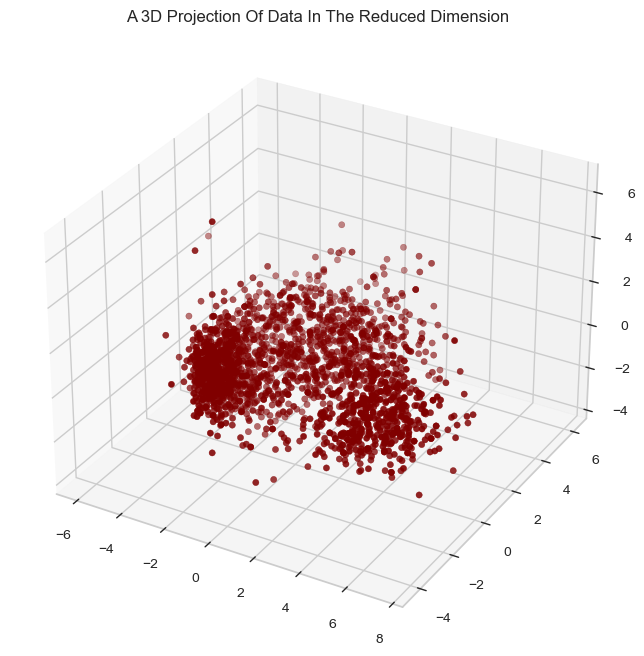

In [20]:
#A 3D Projection Of Data In The Reduced Dimension
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

## 7.CLUSTERING

Now that I have reduced the attributes to three dimensions, I will be performing clustering via Agglomerative clustering. Agglomerative clustering is a hierarchical clustering method.  It involves merging examples until the desired number of clusters is achieved.

### 7.1 K-Means Clustering

#### 7.1.1 Performance matrix : Sqare root of the distance

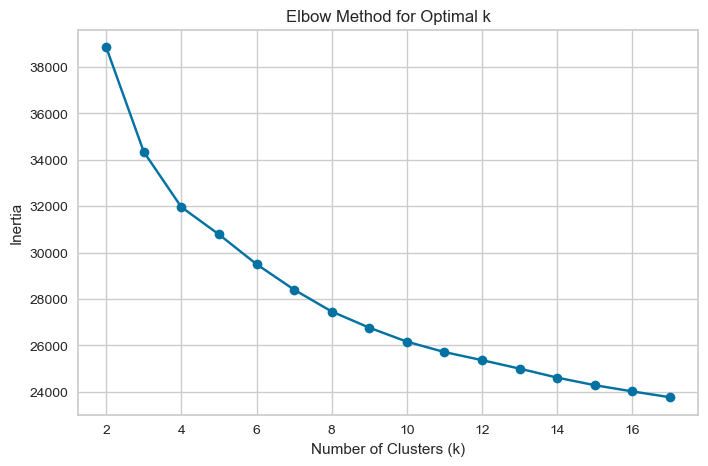

In [21]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

# Calculate inertia for a range of k values
inertia = []
k_values = range(2, 18)
for k in k_values:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(scaled_ds)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()


#### 7.1.2 Performance matrix : Dunn Index

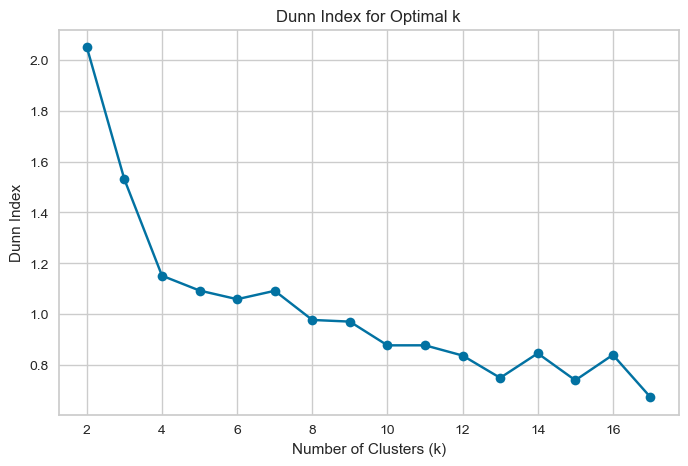

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.datasets import make_blobs

def dunn_index(X, labels, centroids):
    from sklearn.metrics import pairwise_distances

    if centroids.shape[0] < 2:
        return 0  # Not enough centroids to compute Dunn Index

    # Pairwise distances between centroids
    distances = pairwise_distances(centroids, centroids)
    np.fill_diagonal(distances, np.inf)  # Exclude distances of centroids to themselves
    min_inter_cluster_distance = np.min(distances)  # Minimum non-zero distance between centroids
    
    # Calculate the average intra-cluster distance
    intra_cluster_distances = []
    for i in np.unique(labels):
        cluster_points = X[labels == i]
        if cluster_points.shape[0] > 1:
            dist = pairwise_distances(cluster_points)
            np.fill_diagonal(dist, np.inf)  # Exclude distances of points to themselves
            intra_cluster_distance = np.mean(np.min(dist, axis=1))
            intra_cluster_distances.append(intra_cluster_distance)

    if not intra_cluster_distances:
        return 0  # No valid intra-cluster distances

    max_intra_cluster_distance = np.max(intra_cluster_distances)
    
    # Dunn Index
    return min_inter_cluster_distance / max_intra_cluster_distance if max_intra_cluster_distance != 0 else 0


# Compute Dunn Index for different values of k
k_range = range(2, 18)  # Starting from k=2 as Dunn Index is not defined for k=1
dunn_indices = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
    labels = kmeans.fit_predict(scaled_ds)
    centroids = kmeans.cluster_centers_
    
    dunn_idx = dunn_index(scaled_ds, labels, centroids)
    dunn_indices.append(dunn_idx)

# Plot Dunn Index
plt.figure(figsize=(8, 5))
plt.plot(k_range, dunn_indices, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Dunn Index')
plt.title('Dunn Index for Optimal k')
plt.grid(True)
plt.show()


In [23]:
k = 4  # Number of clusters
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
labels = kmeans.fit_predict(scaled_ds)
centroids = kmeans.cluster_centers_
data["Clusters_KM"]= labels

### 7.2 DB SCAN

In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import silhouette_score

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'eps': [0.1, 0.2, 0.3, 0.4, 0.5],
    'min_samples': [3, 5, 10, 15]
}

# To store the best model and its performance
best_score = -1
best_params = None
best_model = None

# Grid search for hyperparameter tuning
for params in ParameterGrid(param_grid):
    dbscan = DBSCAN(eps=params['eps'], min_samples=params['min_samples'])
    labels = dbscan.fit_predict(scaled_ds)
    
    # Ensure that there are clusters found (excluding noise)
    unique_labels = set(labels)
    if len(unique_labels) > 1 and len(unique_labels) < len(scaled_ds):
        # Calculate silhouette score only if more than 1 cluster and some noise
        try:
            score = silhouette_score(scaled_ds, labels)
            if score > best_score:
                best_score = score
                best_params = params
                best_model = dbscan
        except ValueError:
            # Handle the case where silhouette_score calculation fails
            continue

print(f"Best Parameters: {best_params}")
print(f"Best Silhouette Score: {best_score}")

# Optionally, print the clustering results
if best_model is not None:
    labels = best_model.labels_
    print(labels)
    unique_labels = set(labels)
    print(unique_labels)
    # Exclude noise label (-1) from cluster count
    num_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
    
    print("Clustering Results:")
    print(labels)
    print(f"Number of Clusters: {num_clusters}")
else:
    print("No suitable clustering model found.")


Best Parameters: {'eps': 0.1, 'min_samples': 3}
Best Silhouette Score: -0.34034461373352615
[-1 -1 -1 ... -1 -1 -1]
{0, 1, 2, 3, 4, 5, 6, 7, -1}
Clustering Results:
[-1 -1 -1 ... -1 -1 -1]
Number of Clusters: 8


In [25]:
data["Clusters_DBSCAN"]= labels

### 7.3 Hierarchical clustering

Best Parameters: {'method': 'average', 'metric': 'cosine', 'num_clusters': 2}
Best Silhouette Score: 0.36107231098231457


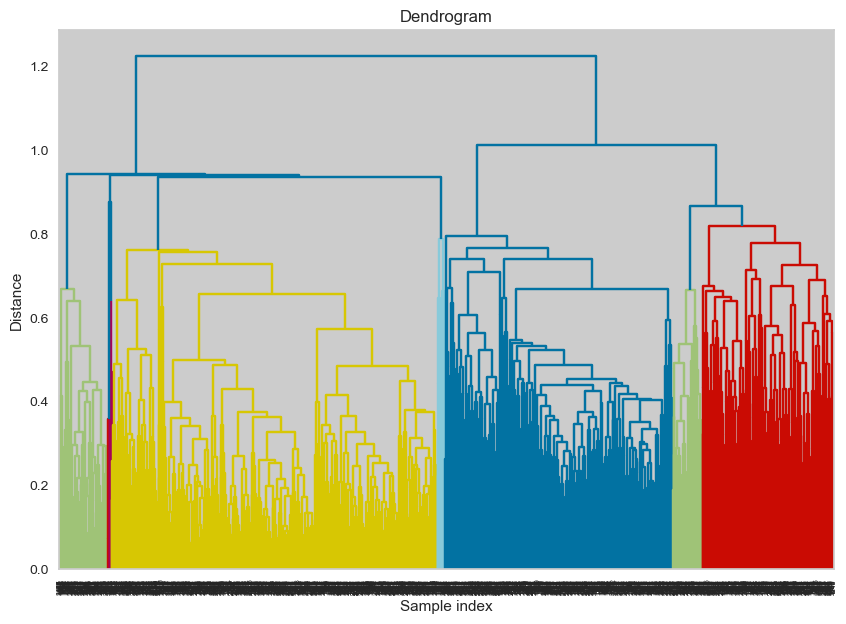

Clustering Results:
[2 1 2 ... 2 2 1]


In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt


# Define the parameter grid for hyperparameter tuning
param_grid = {
    'method': ['single', 'complete', 'average'],
    'metric': ['cosine']
}

# To store the best configuration and its performance
best_score = -1
best_params = None
best_labels = None

# Grid search for hyperparameter tuning
for method in param_grid['method']:
    for metric in param_grid['metric']:
        Z = linkage(scaled_ds, method=method, metric=metric)
        

        for num_clusters in range(2, 18):
            # Form flat clusters
            labels = fcluster(Z, num_clusters, criterion='maxclust')
            
            # Calculate silhouette score
            if len(set(labels)) > 1:
                try:
                    score = silhouette_score(scaled_ds, labels, metric=metric)
                    if score > best_score:
                        best_score = score
                        best_params = {'method': method, 'metric': metric, 'num_clusters': num_clusters}
                        best_labels = labels
                except ValueError:
                    # Handle cases where silhouette_score calculation fails
                    continue

print(f"Best Parameters: {best_params}")
print(f"Best Silhouette Score: {best_score}")

# Optionally, visualize the dendrogram for the best configuration
if best_params:
    plt.figure(figsize=(10, 7))
    Z = linkage(scaled_ds, method=best_params['method'], metric=best_params['metric'])
    dendrogram(Z)
    plt.title('Dendrogram')
    plt.xlabel('Sample index')
    plt.ylabel('Distance')
    plt.show()

    # Print clustering results
    print("Clustering Results:")
    print(best_labels)

In [27]:
data["Clusters_Hir"]= best_labels

The above cell indicates that four will be an optimal number of clusters for this data. 
Next, we will be fitting the Agglomerative Clustering Model to get the final clusters. 

To examine the clusters formed let's have a look at the 3-D distribution of the clusters. 

## 8. EVALUATING MODELS

Since this is an unsupervised clustering. We do not have a tagged feature to evaluate or score our model. The purpose of this section is to study the patterns in the clusters formed and determine the nature of the clusters' patterns. 

For that, we will be having a look at the data in light of clusters via exploratory data analysis and drawing conclusions. 

Firstly, let us have a look at the group distribution of clustring

### 8.1 K-Means Clustering

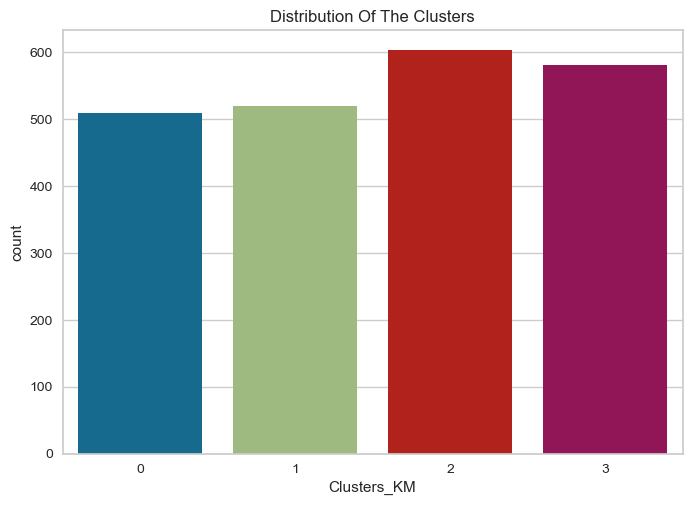

In [28]:
#Plotting countplot of clusters
pl = sns.countplot(x=data["Clusters_KM"])
pl.set_title("Distribution Of The Clusters")
plt.show()

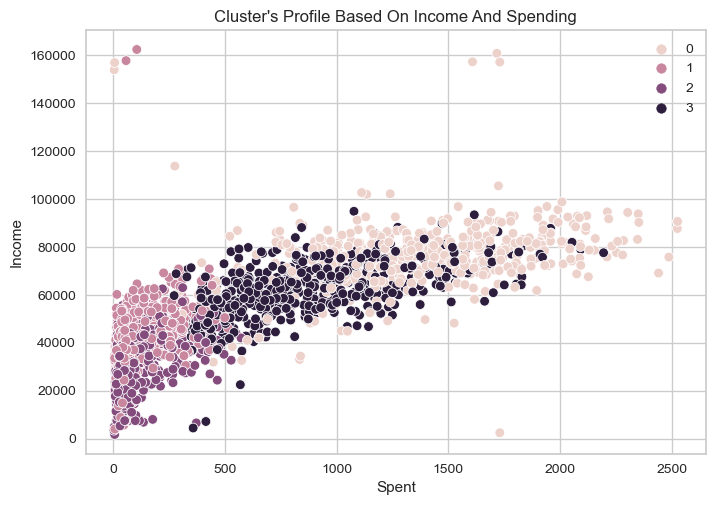

In [29]:
pl = sns.scatterplot(data = data,x=data["Spent"], y=data["Income"],hue=data["Clusters_KM"])
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

### 8.2 Hierarchical clustering

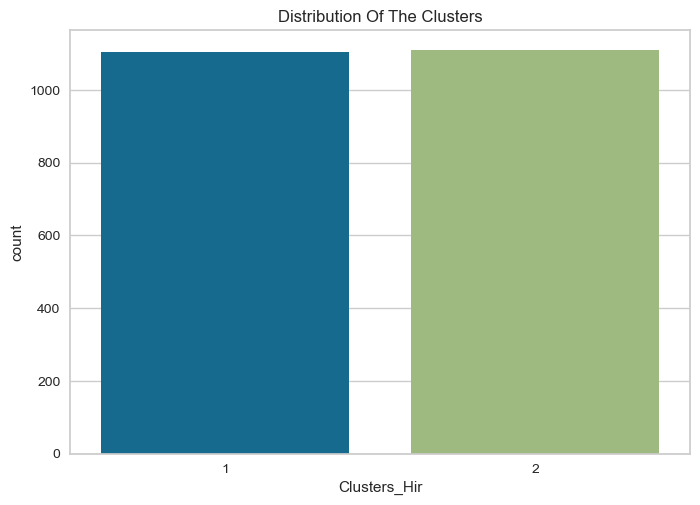

In [30]:
#Plotting countplot of clusters
pl = sns.countplot(x=data["Clusters_Hir"])
pl.set_title("Distribution Of The Clusters")
plt.show()

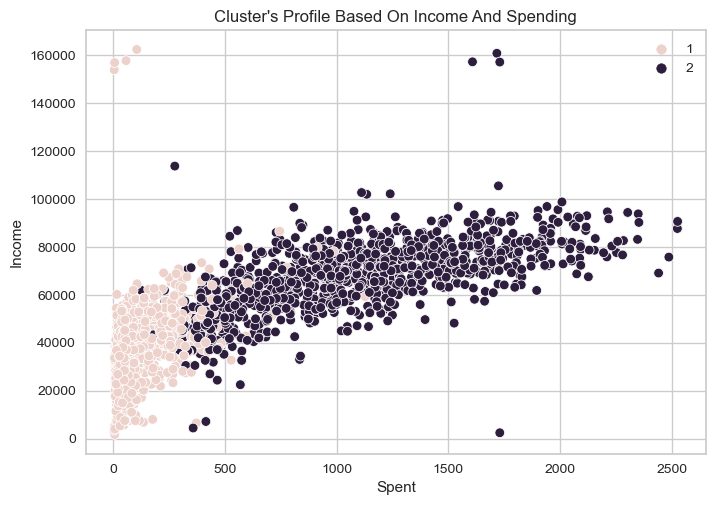

In [31]:
pl = sns.scatterplot(data = data,x=data["Spent"], y=data["Income"],hue=data["Clusters_Hir"])
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

### 8.3 DB SCAN Clustering

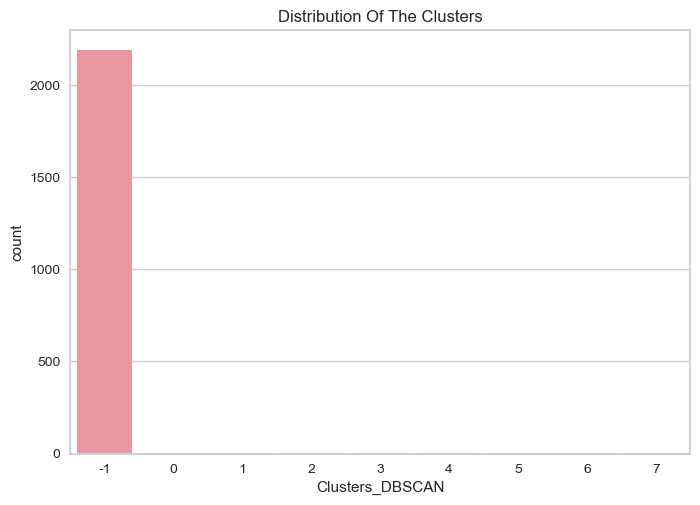

In [32]:
#Plotting countplot of clusters
pl = sns.countplot(x=data["Clusters_DBSCAN"])
pl.set_title("Distribution Of The Clusters")
plt.show()

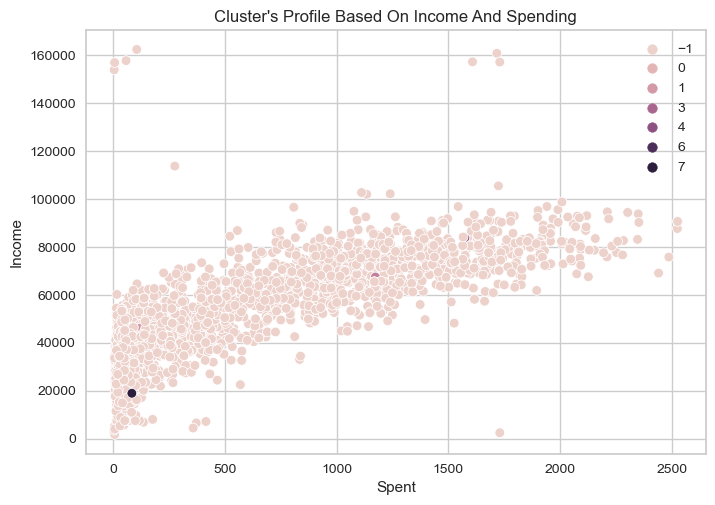

In [33]:
pl = sns.scatterplot(data = data,x=data["Spent"], y=data["Income"],hue=data["Clusters_DBSCAN"])
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

The clusters seem to be fairly distributed in K-means.

## 9. Result Visulization

**Income vs  spending plot shows the clusters pattern**
* group 0: high spending & average income
* group 1: high spending & high income
* group 2: low spending & low income 
* group 3: high spending & low income  

Next, I will be looking at the detailed distribution of clusters as per the various products in the data. Namely: Wines, Fruits, Meat, Fish, Sweets and Gold

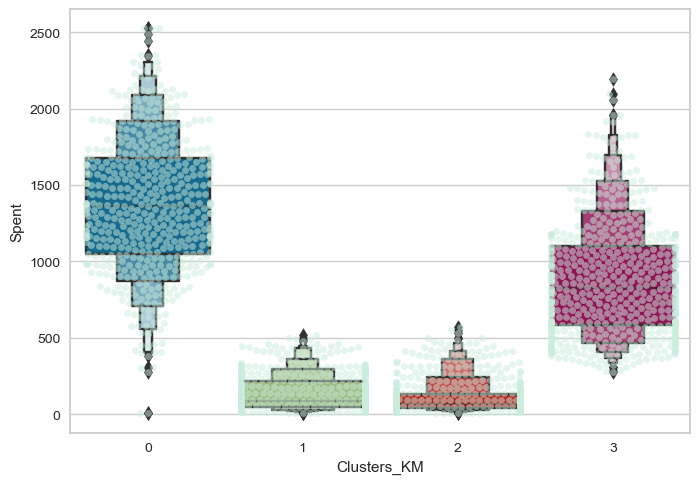

In [34]:
plt.figure()
pl=sns.swarmplot(x=data["Clusters_KM"], y=data["Spent"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=data["Clusters_KM"], y=data["Spent"])
plt.show()


From the above plot, it can be clearly seen that cluster 1 is our biggest set of customers closely followed by cluster 0.
We can explore what each cluster is spending on for the targeted marketing strategies.


Let us next explore how did our campaigns do in the past.

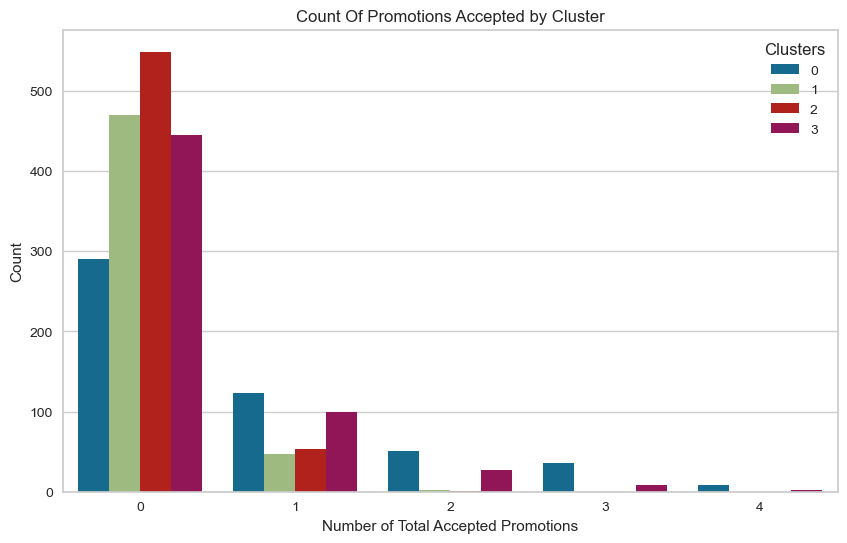

In [36]:
# Create a feature for the sum of accepted promotions
data["Total_Promos"] = (data["AcceptedCmp1"] +
                        data["AcceptedCmp2"] +
                        data["AcceptedCmp3"] +
                        data["AcceptedCmp4"] +
                        data["AcceptedCmp5"])
data['Clusters_KM'] = data['Clusters_KM'].astype(str)
# Plot the count of total promotions accepted
plt.figure(figsize=(10, 6))
pl = sns.countplot(x="Total_Promos", hue="Clusters_KM", data=data)
pl.set_title("Count Of Promotions Accepted by Cluster")
pl.set_xlabel("Number of Total Accepted Promotions")
pl.set_ylabel("Count")
plt.legend(title='Clusters')
plt.show()

There has not been an overwhelming response to the campaigns so far. Very few participants overall. Moreover, no one part take in all 5 of them. Perhaps better-targeted and well-planned campaigns are required to boost sales. 


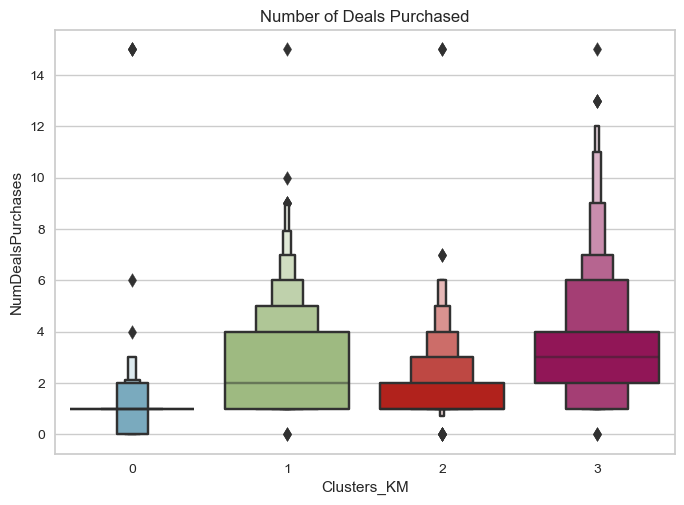

In [37]:
#Plotting the number of deals purchased
plt.figure()
pl=sns.boxenplot(y=data["NumDealsPurchases"],x=data["Clusters_KM"])
pl.set_title("Number of Deals Purchased")
plt.show()

Unlike campaigns, the deals offered did well. It has best outcome with cluster 0 and cluster 3. 
However, our star customers cluster 1 are not much into the deals. 
Nothing seems to attract cluster 2 overwhelmingly 


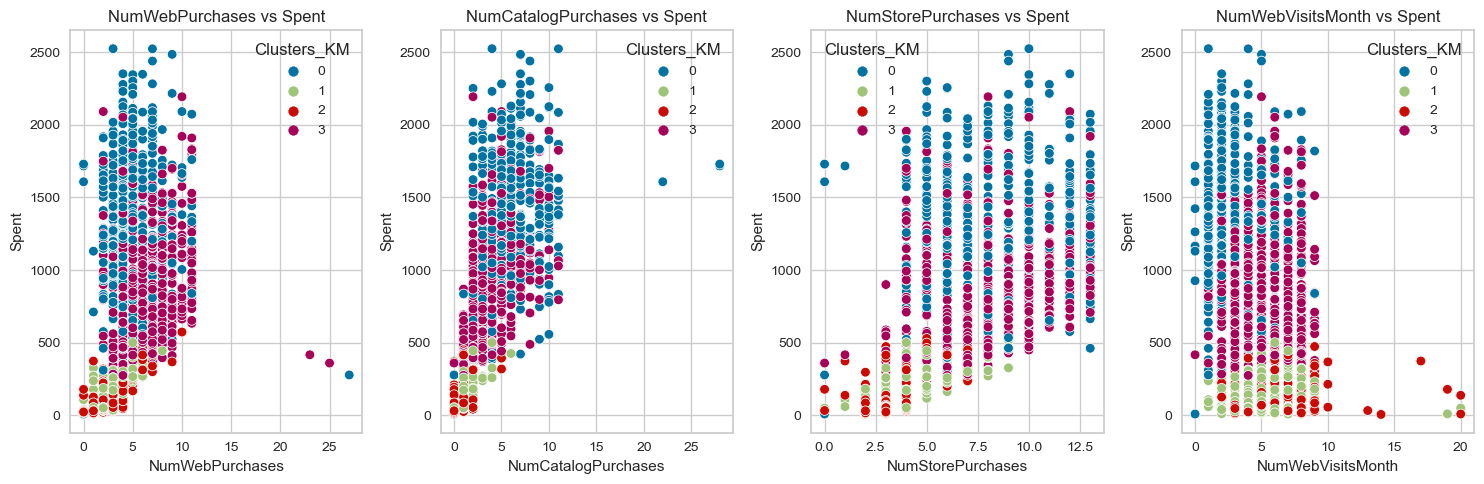

In [38]:
# List of variables to plot
Places = ["NumWebPurchases", "NumCatalogPurchases", "NumStorePurchases", "NumWebVisitsMonth"]

# Number of columns in the grid
n_cols = 4
n_rows = (len(Places) + n_cols - 1) // n_cols  # Calculate number of rows needed

# Create a grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()  # Flatten to easily iterate over

for i, feature in enumerate(Places):
    sns.scatterplot(x=data[feature], y=data["Spent"], hue=data["Clusters_KM"], ax=axes[i])
    axes[i].set_title(f'{feature} vs Spent')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Spent')

# Hide any unused subplots
for j in range(len(Places), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Now that we have formed the clusters and looked at their purchasing habits. 
Let us see who all are there in these clusters. For that, we will be profiling the clusters formed and come to a conclusion about who is our star customer and who needs more attention from the retail store's marketing team.

To decide that I will be plotting some of the features that are indicative of the customer's personal traits in light of the cluster they are in. 
On the basis of the outcomes, I will be arriving at the conclusions. 

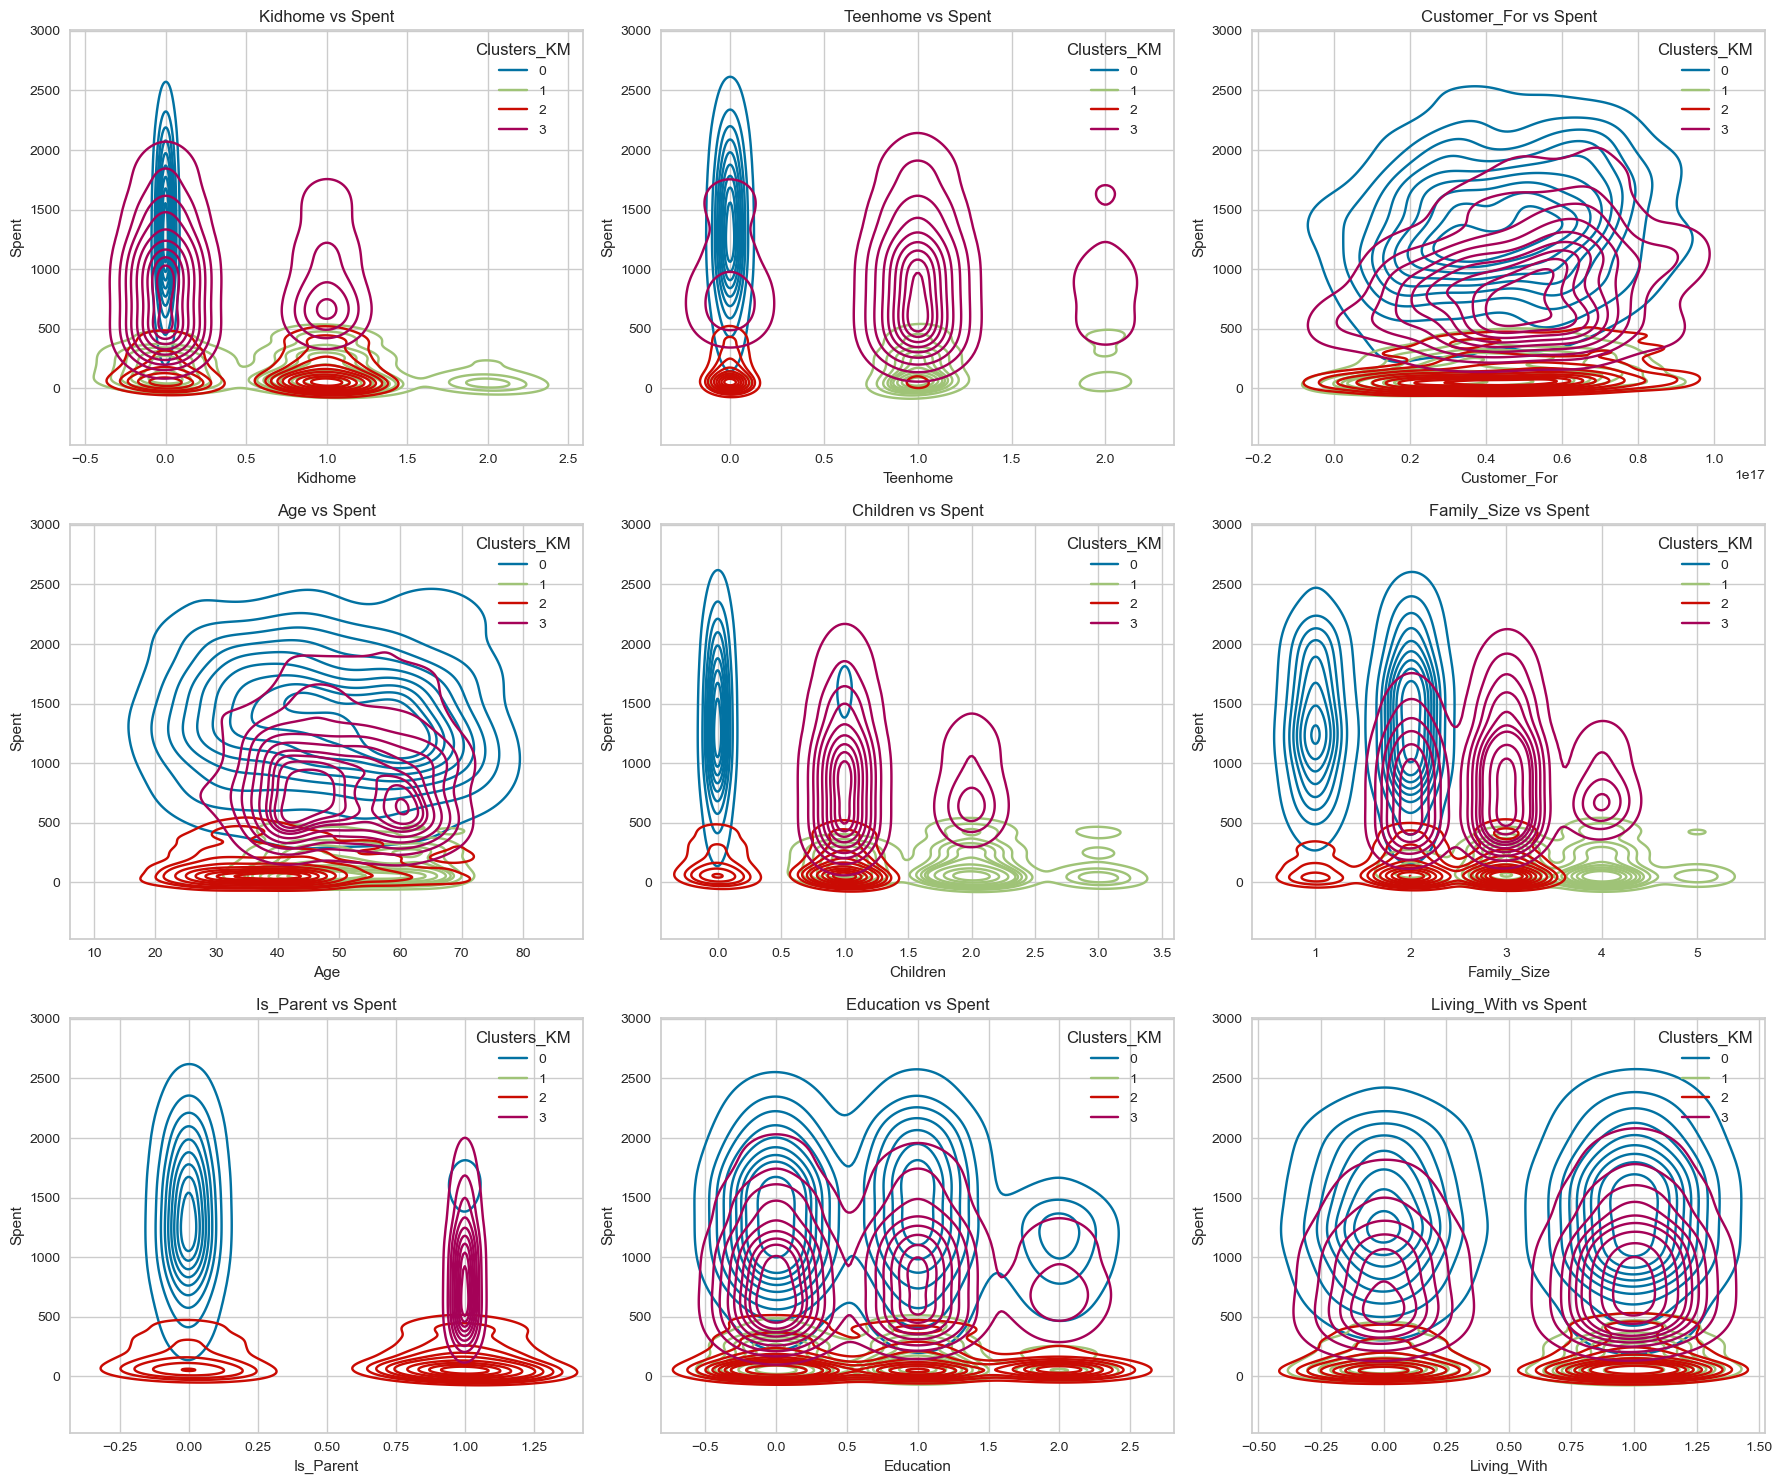

In [39]:
# List of personal attributes to plot
Personal = ["Kidhome", "Teenhome", "Customer_For", "Age", "Children", "Family_Size", "Is_Parent", "Education", "Living_With"]

# Number of columns in the grid
n_cols = 3
n_rows = (len(Personal) + n_cols - 1) // n_cols  # Calculate number of rows needed

# Create a grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()  # Flatten to easily iterate over

for i, feature in enumerate(Personal):
    if data[feature].dtype == 'object':  # If feature is categorical
        sns.kdeplot(x=data[feature].astype(str), y=data["Spent"], hue=data["Clusters_KM"], ax=axes[i], common_norm=False)
    else:
        sns.kdeplot(x=data[feature], y=data["Spent"], hue=data["Clusters_KM"], ax=axes[i], common_norm=False)
    axes[i].set_title(f'{feature} vs Spent')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Spent')

# Hide any unused subplots
for j in range(len(Personal), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**Points to be noted:**

The following information can be deduced about the customers in different clusters.
  